<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# <h1 align="center" id="heading">Subscription Prediction with PySpark and MLlib</h1>

# Spark Environment

Make sure that you open this notebook in your Spark environment!

## Learning Objectives

At the end of this session, you will be able to 

- Explore data with Spark DataFrames 
- Build a pipeline in MLlib for machine learning workflow
- Fit a logistic regression model, make predictions, and evaluate the model

## Part 1: Data Loader

We are using a dataset from the UCI Machine Learning Repository.

1. Use `wget` to download the dataset. Then use `ls` to verify that the `bank.zip` file is downloaded.

In [ ]:
%%sh
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2022-07-28 20:36:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

     0K .......... .......... .......... .......... ..........  8%  821K 1s
    50K .......... .......... .......... .......... .......... 17% 1.64M 0s
   100K .......... .......... .......... .......... .......... 26% 1.66M 0s
   150K .......... .......... .......... .......... .......... 35% 1.63M 0s
   200K .......... .......... .......... .......... .......... 44% 45.7M 0s
   250K .......... .......... .......... .......... .......... 53% 31.1M 0s
   300K .......... .......... .......... .......... .......... 61% 1.70M 0s
   350K .......... .......... .......... .......... .......... 70% 13.1M 0s
   400K ........

In [ ]:
ls

azure/    conf/       hadoop_accessed_config.lst*  metastore_db/
bank.zip  eventlogs/  logs/                        preload_class.lst*


2. Unzip the file and use `ls` to see the files.

In [ ]:
%%sh
unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [ ]:
ls

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
azure/          bank.csv  eventlogs/                   metastore_db/
bank-full.csv   bank.zip  hadoop_accessed_config.lst*  preload_class.ls

## Part 2: Exploring The Data

We will use the direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.

1. Load in the data and look at the columns.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('file:/databricks/driver/bank.csv', header=True, inferSchema=True, sep=';')
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



Here are the columns you should see:

* Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome

* Output variable: y (deposit)


2. Have a peek of the first five observations. Use the `.show()` method.

In [ ]:
# [YOUR CODE HERE]
df.show(5)

+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|  5|  may|     22

To get a prettier result, it can be nice to use Pandas to display our DataFrame. Use the Spark `.take()` method to get the first 5 rows and then convert to a pandas DataFrame. Don't forget to pass along the column names. You should see the same result as above, but in a more aesthetically appealing format.

In [ ]:
import pandas as pd

# [YOUR CODE HERE]
pd.DataFrame(df.take(5), columns = df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


3. We can also perform transformations on our DataFrame using the Pandas commands that we know and love using the [Pandas on Spark API](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html) **(new on Spark versions >= 3.2)**.  Pandas on Spark API was born out of the Databricks project, Koalas 🐨, allows us to use the Pandas commands and aesthetically pleasing output that we know and love distributed on the speed and scale of Spark!  For a nice quickstart on Pandas on Spark, check out this [article](https://towardsdatascience.com/run-pandas-as-fast-as-spark-f5eefe780c45)!  Let's convert our Spark DataFrame to a Pandas on Spark DataFrame!

In [ ]:
import pyspark.pandas as ps

psdf = df.pandas_api()  # did not work on Spark 3.2.1, works on 3.3.0
# psdf = df.to_pandas_on_spark()  # worked on Spark 3.2.1
psdf.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


4. How many datapoints are there in the dataset? Use the `.count()` method.

In [ ]:
# [YOUR CODE HERE]
print(df.count())

4521


5. Use the `.describe()` method to see summary statistics on the features.

    Note that the result of `.describe()` is a Spark DataFrame, so the contents won't be displayed. It only has 5 rows, so you can just convert the whole thing to a pandas DataFrame with `.toPandas()`.

In [ ]:
# to print multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [ ]:
# [YOUR CODE HERE]

# Spark Dataframe
df.describe()
# Display Spark DataFrame
display(df.describe())
# Convert to pandas DataFrame to see categorical columns as well
df.describe().toPandas()
# Pandas in Saprk DataFrame
psdf.describe()

Out[11]: DataFrame[summary: string, age: string, job: string, marital: string, education: string, default: string, balance: string, housing: string, loan: string, contact: string, day: string, month: string, duration: string, campaign: string, pdays: string, previous: string, poutcome: string, y: string]

summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
mean,41.17009511170095,null,null,null,null,1422.6578190665782,null,null,null,15.915284229152842,null,263.96129174961294,2.793629727936297,39.766644547666445,0.5425790754257908,null,null
stddev,10.576210958711263,null,null,null,null,3009.6381424673395,null,null,null,8.247667327229934,null,259.85663262468216,3.1098066601885823,100.12112444301656,1.6935623506071211,null,null
min,19,admin.,divorced,primary,no,-3313,no,no,cellular,1,apr,4,1,-1,0,failure,no
max,87,unknown,single,unknown,yes,71188,yes,yes,unknown,31,sep,3025,50,871,25,unknown,yes


,summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
1,mean,41.17009511170095,None,None,None,None,1422.6578190665782,None,None,None,15.915284229152842,None,263.96129174961294,2.793629727936297,39.766644547666445,0.5425790754257908,None,None
2,stddev,10.576210958711263,None,None,None,None,3009.6381424673395,None,None,None,8.247667327229934,None,259.85663262468216,3.1098066601885823,100.12112444301656,1.6935623506071211,None,None
3,min,19,admin.,divorced,primary,no,-3313,no,no,cellular,1,apr,4,1,-1,0,failure,no
4,max,87,unknown,single,unknown,yes,71188,yes,yes,unknown,31,sep,3025,50,871,25,unknown,yes


,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


6. The above result includes the columns that are categorical, so don't have useful summary statistics. Let's limit to just the numeric features.

    `numeric_features` is defined below to contain the column names of the numeric features.  Notice we use the `zip` functions to iterate through two lists at the same time!
    
    Filter the DataFrame as you would in Pandas to select only the numeric features from the DataFrame and then get the summary statistics on the resulting DataFrame as we did above.

In [ ]:
print(psdf.dtypes.index)
psdf.dtypes.tolist()

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')
Out[12]: [dtype('int32'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int32'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int32'),
 dtype('O'),
 dtype('int32'),
 dtype('int32'),
 dtype('int32'),
 dtype('int32'),
 dtype('O'),
 dtype('O')]

In [ ]:
col_names = [name for name in psdf.dtypes.index]
dtypes = [dtype for dtype in psdf.dtypes.tolist()]

numeric_features = [name for name, dtype in zip(col_names, dtypes) if dtype == 'int32']
# [YOUR CODE HERE]
psdf[numeric_features].describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


7. Run the following code to look at correlation between the numeric features.  Let's convert our Pandas on Spark Datafrane to a Pandas DataFrame using the `to_pandas()` command so that we can plot.  What do you see?

Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []Out[14]: []

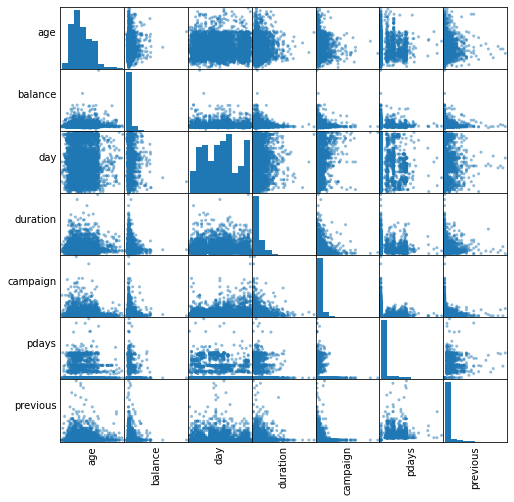

In [ ]:
import pandas as pd

# Convert Pandas on Spark DataFrame to Spark DataFrame
numeric_data = psdf[numeric_features].to_pandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n - 1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

There aren't any highly correlated variables, so we will keep them all for the model. It’s obvious that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the model. However, day and month columns are not really useful, so we will remove these two columns.

8. Use the `.drop()` method to drop the `month` and `day` columns.
    
    Note that this method returns a new DataFrame, so save that result as `sdf`.

    Use the `.dtypes()` method to verify that `sdf` now has the correct columns.

In [ ]:
# [YOUR CODE HERE]
# Pandas in Spark Dataframe
sdf = psdf.drop(['day', 'month'])
sdf.dtypes

Out[15]: age           int32
job          object
marital      object
education    object
default      object
balance       int32
housing      object
loan         object
contact      object
day           int32
month        object
duration      int32
campaign      int32
pdays         int32
previous      int32
poutcome     object
y            object
dtype: object

In [ ]:
# [YOUR CODE HERE]
# Drop columns in Spark DataFrame
# We will use it in Part 4
df = df.drop('day', 'month')
df.dtypes


Out[16]: [('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string')]

## Part 3: Preparing Data for Machine Learning

What follows is something analagous to a dataloader pipeline in Tensorflow--we're going to chain together some transformations that will convert our categorical variables into a one-hot format more amenable to training a machine learning model. The next code cell just sets this all up, but it doesn't run these transformations on our data yet.

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

The code is taken from [databricks’ official site](https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example) and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

1. Complete the code by completing the assignment of `assembler`. Use `VectorAssembler` and pass in `assemblerInputs` as `inputCols` and name the `outputCol` `"features"`.

In [ ]:
from pyspark.ml.feature import OneHotEncoder , StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features') # [YOUR CODE HERE]
stages += [assembler]

## Part 4: Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

1. Fit a pipeline on df.

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(df) # [YOUR CODE HERE]

2. Transform `pipelineModel` on `df` and assign this to variable `transformed_df`.

In [ ]:
transformed_df = pipelineModel.transform(df) # [YOUR CODE HERE]
transformed_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = false)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationclassVec: vector (nullable = true)
 |-- defaultIndex: double (nullable = false)
 |-- defaultclassVec: vector (nullable = true)
 |-- housingIndex: double (nullable = false)
 |-- hou

From the transformation, we'd like to take the `label` and `features` columns as well as the original columns from `sdf.`

3. Use the `.select()` method to pull these columns from the `transformed_df` and reassign the resulting DataFrame to `sdf`.

In [ ]:
selectedCols = ['label', 'features'] + df.columns
df = transformed_df.select(selectedCols) # [YOUR CODE HERE]
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



4. View the first five rows of the `df` DataFrame. Use either of the methods we did in Part 2:
    * `.show()` method
    * `.take()` method and convert result to a Pandas DataFrame

In [ ]:
# [YOUR CODE HERE]
df.show(5)


+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+
|label|            features|age|        job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|  y|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+
|  0.0|(30,[8,11,15,16,1...| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular|      79|       1|   -1|       0| unknown| no|
|  0.0|(30,[4,11,13,16,1...| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular|     220|       1|  339|       4| failure| no|
|  0.0|(30,[0,12,14,16,1...| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular|     185|       1|  330|       1| failure| no|
|  0.0|(30,[0,11,14,16,1...| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|     199|       4|

5. Randomly split the dataset in training and test sets, with 70% of the data in the training set and the remaining 30% in the test set.

    Hint: Call the `.randomSplit()` method.

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed=42) # [YOUR CODE HERE]

6. What are the sizes of the training and test sets?

In [ ]:
# [YOUR CODE HERE]
print(f"Training dataset: {train.cache().count()}")
print(f"Test dataset: {test.count()}")


Training dataset: 3233
Test dataset: 1288


## Part 5: Logistic Regression Model

- You can build a RandomForestClassifier with : from pyspark.ml.classification import RandomForestClassifier
- You can build a Gradient-Boosted Tree Classifier with : from pyspark.ml.classification import GBTClassifier

1. Fit a LogisticRegression with `featuresCol` as `"features"`, `labelCol` as `"label"` and a `maxIter` of 10.

In [ ]:
from pyspark.ml.classification import LogisticRegression

# [YOUR CODE HERE]
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lrModel = lr.fit(train)

2. We can obtain the coefficients by using LogisticRegressionModel’s attributes. Look at the following plot of the beta coefficients.

Out[25]: [<matplotlib.lines.Line2D at 0x7fa567f3c130>]Out[25]: Text(0, 0.5, 'Beta Coefficients')

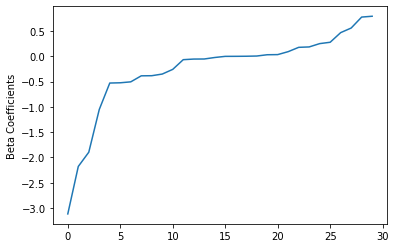

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

3. Use the `.transform()` method to make predictions and save them as `predictions`.

In [ ]:
predictions = lrModel.transform(test) # [YOUR CODE HERE]

4. View the first 10 rows of the `predictions` DataFrame.

In [ ]:
# [YOUR CODE HERE]
predictions.show(10)

+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|label|            features|age|       job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|  y|       rawPrediction|         probability|prediction|
+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...| 33|management|married|secondary|     no|     11|    yes|  no|cellular|     104|       3|   -1|       0| unknown| no|[3.34459257546136...|[0.96592731579825...|       0.0|
|  0.0|(30,[0,11,13,16,1...| 36|management|married|secondary|     no|    644|    yes|  no|cellular|      54|       2|   -1|       0| unknown| no|[3.49558283425373...|[0.97056182588136...|       0.0|
|  0.

In [ ]:
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[3.34459257546136...|       0.0|[0.96592731579825...|
| 36|management|  0.0|[3.49558283425373...|       0.0|[0.97056182588136...|
| 44|management|  0.0|[3.88599495292370...|       0.0|[0.97988550340667...|
| 48|management|  0.0|[1.00530053953457...|       0.0|[0.73209945072549...|
| 58|management|  0.0|[3.15034616239782...|       0.0|[0.95892235939552...|
| 60|management|  0.0|[2.57955929510873...|       0.0|[0.92953440831591...|
| 30|management|  0.0|[0.60079049595689...|       0.0|[0.64583713841231...|
| 40|management|  0.0|[3.12468073552480...|       0.0|[0.95789939862378...|
| 32|management|  0.0|[4.27596651573881...|       0.0|[0.98629191432219...|
| 34|management|  0.0|[2.56254537926277...|       0.0|[0.92841181667033...|
+---+-------

5. What is the area under the curve?

    You can find it with the `evaluator.evaluate()` function.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
# [YOUR CODE HERE]
print("Area under the curve:", evaluator.evaluate(predictions))

Area under the curve: 0.874418791085453


## OPTIONAL: HyperParameter Tuning a Gradient-Boosted Tree Classifier

1. Fit and make predictions using `GBTClassifier`. The syntax will match what we did above with `LogisticRegression`.

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.22428478288498...|       0.0|[0.92045678297830...|
| 36|management|  0.0|[1.30612818723414...|       0.0|[0.93164622568969...|
| 44|management|  0.0|[1.20116550198106...|       0.0|[0.91700488159109...|
| 48|management|  0.0|[0.74718401168223...|       0.0|[0.81673298401522...|
| 58|management|  0.0|[1.25409700523478...|       0.0|[0.92471425789957...|
| 60|management|  0.0|[0.27768603688369...|       0.0|[0.63538105272691...|
| 30|management|  0.0|[-0.1675670653450...|       1.0|[0.41699193696913...|
| 40|management|  0.0|[1.31636773767878...|       0.0|[0.93293889427248...|
| 32|management|  0.0|[1.26094374616973...|       0.0|[0.92566204102669...|
| 34|management|  0.0|[0.83120327588185...|       0.0|[0.84056078954223...|
+---+-------

2. Run some cross validation to compare different parameters.

    Note that it can take a while because it's training over many gradient boosted trees. Give it at least 10 minutes to complete.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

Out[31]: 0.8635934171648425

## Acknowledgements

This notebook is adapted from [Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)